In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [10]:
WORKING_DIR = '/scratch/msc24h18/msc_project'
FILE_PATH = 'data/LBE247_analyzed/LBE247_ID301XR1000Oct/pulsedAmplitudeSweep_DCIV_20240919143913/pulsedAmplitudeSweep_DCIV[LBE247_ID301XR1000Oct(1)]20240919144143/pulsedAmplitudeSweep_DCIV[LBE247_ID301XR1000Oct(1)]20240919144143_Summary.dat'

data = pd.read_csv(os.path.join(WORKING_DIR, FILE_PATH), skiprows=6)

data.head()

,Pulse Number,index,Pulse Amplitude (V),R_low (ohm),R_high (ohm)
0,1,2,0.2,4.618938e+09,5.227392e+09
1,2,3,0.3,4.649000e+09,5.279831e+09
2,3,4,0.4,4.814636e+09,5.482456e+09
3,4,5,0.5,5.157298e+09,5.889282e+09
4,5,6,0.6,5.707763e+09,6.480881e+09


Number of LTP pulses: 22
Number of LTD pulses: 24


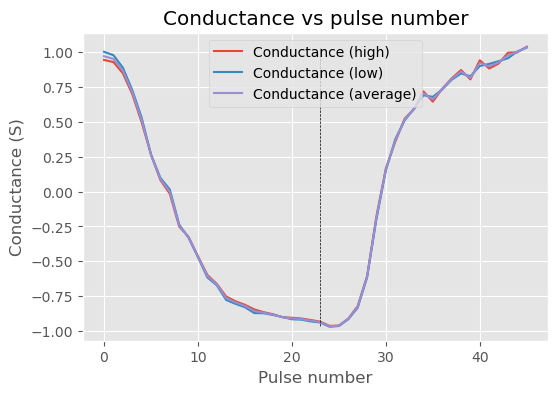

In [11]:
conductance_l = np.array(1 / data['R_high (ohm)'])
conductance_h = np.array(1 / data['R_low (ohm)'])
conductance = (conductance_l + conductance_h) / 2


def normalize(c):
    return 2 * (c - c.mean()) / (c.max() - c.min())


conductance_l = normalize(conductance_l)
conductance_h = normalize(conductance_h)
conductance = normalize(conductance)

# ltp pulses are expected to be positive for fitting to work
pulses = np.array([-1 if v > 0 else 1 for v in data['Pulse Amplitude (V)']])
conductance_ltp = conductance[np.where(pulses == 1)[0]]
conductance_ltd = conductance[np.where(pulses == -1)[0]]
pulse_change_idx = np.where(np.diff(pulses) != 0)[0]

print(f"Number of LTP pulses: {len(conductance_ltp)}")
print(f"Number of LTD pulses: {len(conductance_ltd)}")

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(conductance_h, label='Conductance (high)')
ax.plot(conductance_l, label='Conductance (low)')
ax.plot(conductance, label='Conductance (average)')
ax.vlines(pulse_change_idx, conductance.min(), conductance.max(), color='k', ls='--', lw=0.5)
ax.set(xlabel="Pulse number", ylabel="Conductance (S)", title="Conductance vs pulse number")
ax.legend()
plt.show()

In [12]:
from aihwkit.utils.fitting import fit_measurements


def fit_model(device_config):
    params = {'dw_min': (0.1, 0.001, 1.0),
              'up_down': (0.0, -0.99, 0.99),
              'w_max': (1.0, 0.1, 2.0),
              'w_min': (-1.0, -2.0, -0.1),
              }

    result, device_config_fit, best_model_fit = fit_measurements(
        params,
        pulses,
        conductance,
        device_config)

    print(device_config_fit)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(conductance, label='Measured')
    ax.plot(best_model_fit, label='Fit')
    ax.vlines(pulse_change_idx, conductance.min(), conductance.max(), color='k', ls='--', lw=0.5)
    ax.set(xlabel="Pulse number", ylabel="Conductance (S)", title=str(device_config))
    ax.legend()
    plt.show()

    # return result, device_config_fit, best_model_fit

ConstantStepDevice(
    dw_min=0.15509070989180487,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.1139781296057536,
    up_down_dtod=0.0,
    w_max=0.9574154877708685,
    w_max_dtod=0.0,
    w_min=-0.9401868243240388,
    w_min_dtod=0.0
)


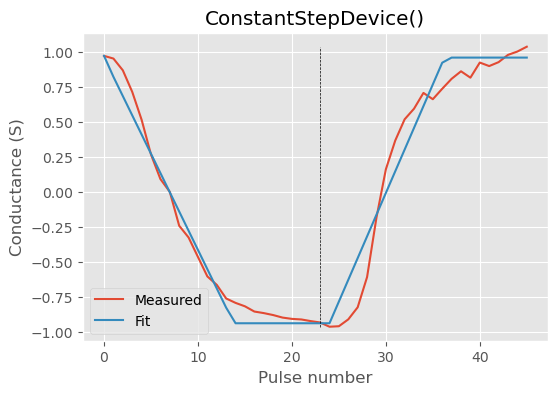

ExpStepDevice(
    dw_min=0.1606908495610809,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.14194202615122475,
    up_down_dtod=0.0,
    w_max=0.9546512764738774,
    w_max_dtod=0.0,
    w_min=-0.9544273758782333,
    w_min_dtod=0.0
)


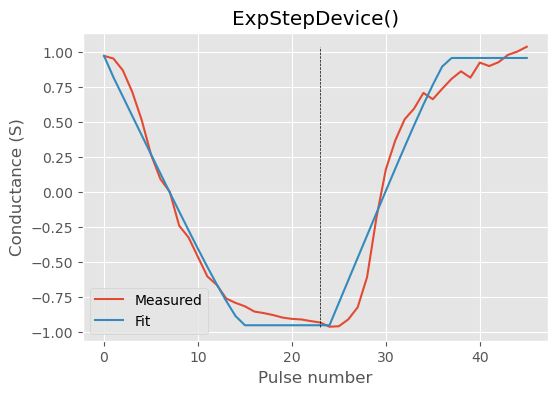

LinearStepDevice(
    dw_min=0.15509070989180487,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.1139781296057536,
    up_down_dtod=0.0,
    w_max=0.9574154877708685,
    w_max_dtod=0.0,
    w_min=-0.9401868243240388,
    w_min_dtod=0.0,
    gamma_up_dtod=0.0,
    gamma_down_dtod=0.0
)


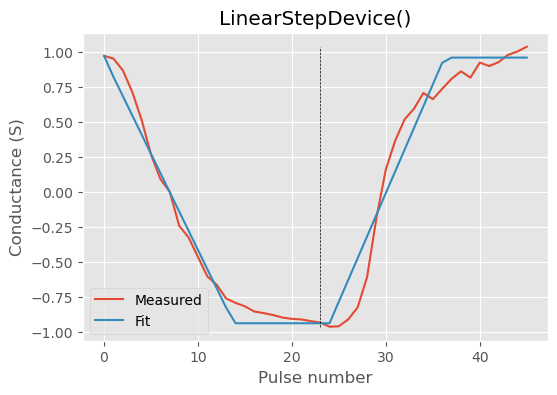

PowStepDevice(
    dw_min=0.3114252862615921,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.3340299522518455,
    up_down_dtod=0.0,
    w_max=1.327952256685024,
    w_max_dtod=0.0,
    w_min=-1.6008659285072657,
    w_min_dtod=0.0,
    pow_gamma_dtod=0.0
)


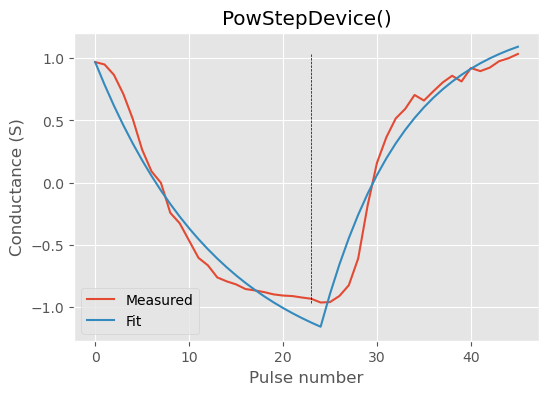

SoftBoundsDevice(
    dw_min=0.1412111494143556,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=0.19694883481025216,
    up_down_dtod=0.0,
    w_max=1.3248836462395208,
    w_max_dtod=0.0,
    w_min=-1.5998312003783894,
    w_min_dtod=0.0
)


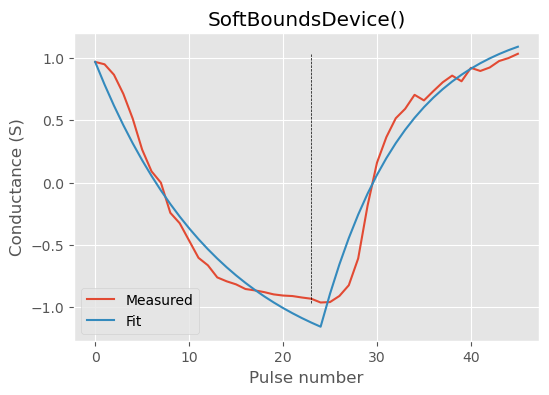

In [13]:
from aihwkit.simulator.configs import (
    ConstantStepDevice,
    ExpStepDevice,
    LinearStepDevice,
    PowStepDevice,
    SoftBoundsDevice
)

fit_model(ConstantStepDevice())
fit_model(ExpStepDevice())
fit_model(LinearStepDevice())
fit_model(PowStepDevice())
fit_model(SoftBoundsDevice())

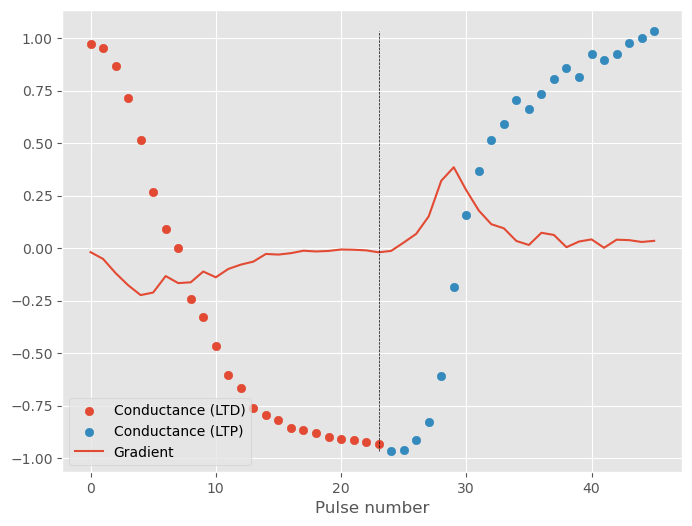

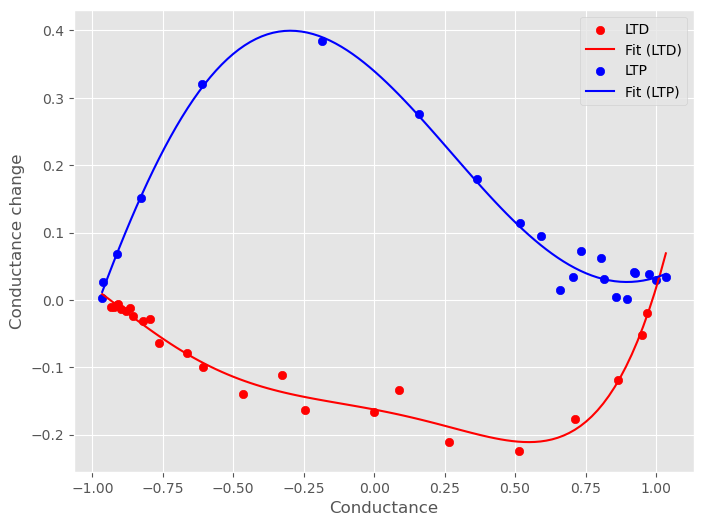

In [14]:
from numpy.polynomial.polynomial import Polynomial
pulses_ltp = np.where(pulses == 1)[0]
pulses_ltd = np.where(pulses == -1)[0]

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(pulses_ltd, conductance_ltd, label='Conductance (LTD)')
ax.scatter(pulses_ltp, conductance_ltp, label='Conductance (LTP)')
# ax.plot(conductance)
ax.plot(np.gradient(conductance), label='Gradient')
ax.vlines(pulse_change_idx, conductance.min(), conductance.max(), color='k', ls='--', lw=0.5)
ax.set(xlabel="Pulse number")
ax.legend()
plt.show()

grad_ltd = np.gradient(conductance_ltd)
grad_ltp = np.gradient(conductance_ltp)

fit_degree = 5
fit_grad_ltd = Polynomial.fit(conductance_ltd, grad_ltd, fit_degree)
fit_grad_ltp = Polynomial.fit(conductance_ltp, grad_ltp, fit_degree)

xvals = np.linspace(conductance.min(), conductance.max(), 100)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(conductance_ltd, grad_ltd, label='LTD', color='r')
ax.plot(xvals, fit_grad_ltd(xvals), label='Fit (LTD)', color='r')

ax.scatter(conductance_ltp, grad_ltp, label='LTP', color='b')
ax.plot(xvals, fit_grad_ltp(xvals), label='Fit (LTP)', color='b')

ax.set(xlabel="Conductance", ylabel="Conductance change")
ax.legend()
plt.show()

PiecewiseStepDevice(
    dw_min=0.16280268424125735,
    dw_min_dtod=0.0,
    dw_min_std=0.0,
    reset_std=0.0,
    up_down=-0.13286048664583006,
    up_down_dtod=0.0,
    w_max=1.023339938169942,
    w_max_dtod=0.0,
    w_min=-1.0223991267499515,
    w_min_dtod=0.0,
    piecewise_up=[
        0.16383697825609492,
        0.258294708959813,
        0.650344304604337,
        1.0072149467538893,
        1.3249598157634193,
        1.6007114177524837,
        1.8326108680913162,
        2.019737174886899,
        2.1620365224690334,
        2.2602515548764144,
        2.3158506593426975,
        2.330957249782574,
        2.308279050277839,
        2.251037378563464,
        2.1628964295136694,
        2.0478925586279932,
        1.9103635655173652,
        1.7548779773901748,
        1.5861643325383457,
        1.4090404638234044,
        1.2283427821625543,
        1.0488555600147444,
        0.8752402148667406,
        0.7119645927192002,
        0.5632322515727387,
        0.4329117

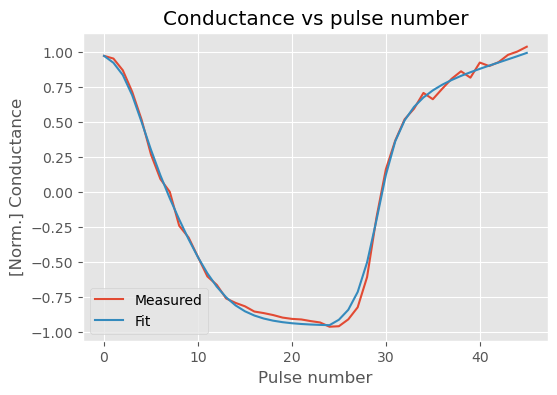

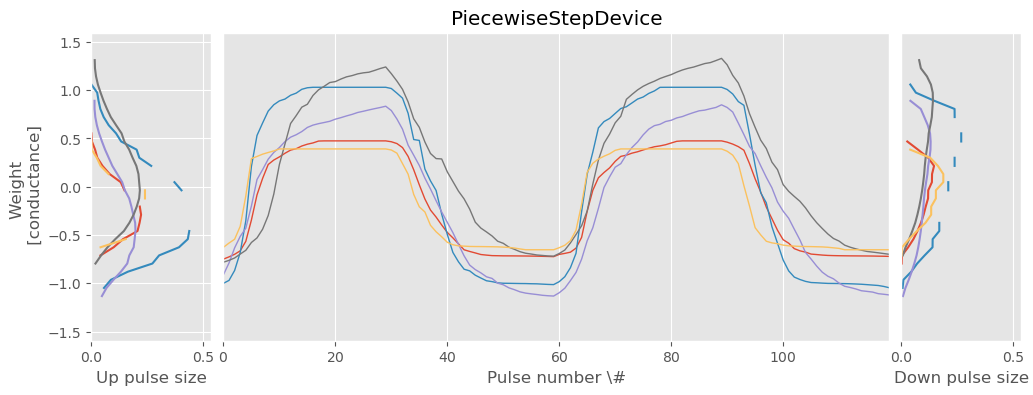

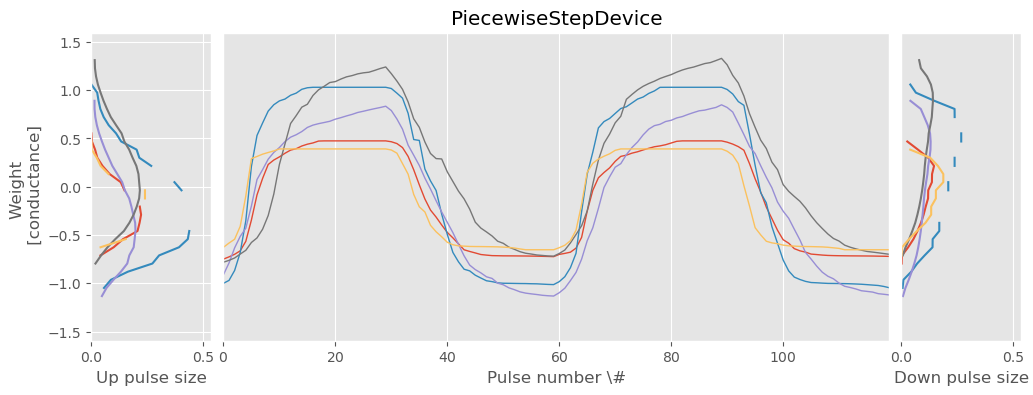

In [30]:
from aihwkit.utils.visualization import get_tile_for_plotting, compute_pulse_response
from aihwkit.simulator.configs import build_config
from aihwkit.utils.fitting import fit_measurements
from aihwkit.simulator.configs import PiecewiseStepDevice
from aihwkit.utils.visualization import plot_device_compact

condvals = np.linspace(-1, 1, 32)
fit_ltp_vals = np.abs(fit_grad_ltp(condvals))
fit_ltd_vals = np.abs(fit_grad_ltd(condvals))

params = {'dw_min': (0.1, 0.001, 1.0),
          'up_down': (0.0, -0.99, 0.99),
          'w_max': (1.0, 0.1, 2.0),
          'w_min': (-1.0, -2.0, -0.1),
          }

result, pw_device_fit, pw_device_response = fit_measurements(
    params,
    pulses,
    conductance,
    PiecewiseStepDevice(
        piecewise_up=list(fit_ltp_vals),
        piecewise_down=list(fit_ltd_vals)
    ))

# rescale dw_min and conductance gradient
scale = (np.mean(fit_ltp_vals) + np.mean(fit_ltd_vals)) / 2
pw_device_fit.dw_min *= scale
pw_device_fit.piecewise_up = list(fit_ltp_vals / scale)
pw_device_fit.piecewise_down = list(fit_ltd_vals / scale)

print(pw_device_fit)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(conductance, label='Measured')
ax.plot(pw_device_response, label='Fit')
ax.set(xlabel="Pulse number", ylabel="[Norm.] Conductance", title="Conductance vs pulse number")
ax.legend()
plt.show()

pw_device_fit.dw_min_dtod = 0.3
pw_device_fit.dw_min_std = 0.3
pw_device_fit.w_min_dtod = 0.3
pw_device_fit.w_max_dtod = 0.3
pw_device_fit.write_noise_std = 0

rpu_config = build_config('sgd', pw_device_fit)
plot_device_compact(pw_device_fit, n_steps=30, n_traces=5, n_loops=2)